<a href="https://colab.research.google.com/github/EmilyPhang/Social-Media-Computing-Project-Sentiment-Analysis-of-Sephora-Reviews/blob/main/CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as pl

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load Split Data
train_df = pd.read_csv("/content/drive/MyDrive/Dataset/train.csv")
val_df = pd.read_csv("/content/drive/MyDrive/Dataset/val.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Dataset/test.csv")

In [4]:
# Label Encoding
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['sentiment_label'])
val_df['label'] = label_encoder.transform(val_df['sentiment_label'])
test_df['label'] = label_encoder.transform(test_df['sentiment_label'])

In [5]:
# Parameters for Tokenization
vocab_size = 10000  # Vocabulary size
max_length = 128    # Maximum sequence length
embedding_dim = 100 # Embedding dimension

In [6]:
# Tokenization
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['cleaned_review'])

In [7]:
# Prepare cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_preds = []
all_labels = []
results = []
fold = 1

In [8]:
def build_cnn_model():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # 3 classes for sentiment
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def compute_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    acc = accuracy_score(y_true, y_pred)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

In [9]:
for train_index, val_index in skf.split(train_df['cleaned_review'], train_df['label']):
    print(f"\nFold {fold}/5")

    # Split data
    train_fold = train_df.iloc[train_index].copy()
    val_fold = train_df.iloc[val_index].copy()

    # Convert text to sequences
    train_sequences = tokenizer.texts_to_sequences(train_fold['cleaned_review'].astype(str))
    val_sequences = tokenizer.texts_to_sequences(val_fold['cleaned_review'].astype(str))

    # Pad sequences
    train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
    val_padded = pad_sequences(val_sequences, maxlen=max_length, padding='post', truncating='post')

    # Labels
    train_labels = train_fold['label'].values
    val_labels = val_fold['label'].values

    # Build and train model
    model = build_cnn_model()
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

    model.fit(
        train_padded, train_labels,
        epochs=10,
        batch_size=16,
        validation_data=(val_padded, val_labels),
        callbacks=[early_stopping],
        verbose=1
    )

    # Predict on validation fold
    val_preds = np.argmax(model.predict(val_padded), axis=1)

    all_preds.extend(val_preds)
    all_labels.extend(val_labels)

    # Compute metrics
    metrics = compute_metrics(val_labels, val_preds)
    cm = confusion_matrix(val_labels, val_preds)

    if cm.shape[0] == 3:
        tp = np.diag(cm).sum()
        fn = cm.sum(axis=1) - np.diag(cm)
        fp = cm.sum(axis=0) - np.diag(cm)
        tn = cm.sum() - (fp + fn + np.diag(cm))
        fn = fn.sum()
        fp = fp.sum()
        tn = tn.sum()
    else:
        tn, fp, fn, tp = [0] * 4

    results.append({
        "Fold": fold,
        "Accuracy": metrics["accuracy"],
        "Precision": metrics["precision"],
        "Recall": metrics["recall"],
        "F1 Score": metrics["f1"],
        "TP": tp,
        "TN": tn,
        "FP": fp,
        "FN": fn
    })

    fold += 1


Fold 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.3860 - loss: 1.0815 - val_accuracy: 0.5716 - val_loss: 0.8581
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6335 - loss: 0.7773 - val_accuracy: 0.6677 - val_loss: 0.6945
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7966 - loss: 0.4889 - val_accuracy: 0.6870 - val_loss: 0.6465
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9192 - loss: 0.2623 - val_accuracy: 0.6880 - val_loss: 0.6887
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9711 - loss: 0.1109 - val_accuracy: 0.6848 - val_loss: 0.8319
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

Fold 2/5
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


234/234 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3790 - loss: 1.0737 - val_accuracy: 0.5833 - val_loss: 0.8976
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6362 - loss: 0.7998 - val_accuracy: 0.6506 - val_loss: 0.7577
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7880 - loss: 0.5145 - val_accuracy: 0.6709 - val_loss: 0.7545
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8978 - loss: 0.3029 - val_accuracy: 0.6731 - val_loss: 0.8138
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9646 - loss: 0.1382 - val_accuracy: 0.6677 - val_loss: 0.9653
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Fold 3/5
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


234/234 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3875 - loss: 1.0830 - val_accuracy: 0.5288 - val_loss: 0.9064
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5965 - loss: 0.8353 - val_accuracy: 0.6752 - val_loss: 0.7122
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7654 - loss: 0.5491 - val_accuracy: 0.6731 - val_loss: 0.6925
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8701 - loss: 0.3509 - val_accuracy: 0.6955 - val_loss: 0.7545
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9469 - loss: 0.1942 - val_accuracy: 0.6987 - val_loss: 0.8449
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Fold 4/5
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


234/234 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3816 - loss: 1.0850 - val_accuracy: 0.4957 - val_loss: 0.9730
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6127 - loss: 0.8364 - val_accuracy: 0.6261 - val_loss: 0.7557
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7965 - loss: 0.5146 - val_accuracy: 0.6571 - val_loss: 0.7414
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9096 - loss: 0.2783 - val_accuracy: 0.6474 - val_loss: 0.8662
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9679 - loss: 0.1205 - val_accuracy: 0.6603 - val_loss: 1.0442
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

Fold 5/5
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


234/234 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3781 - loss: 1.0786 - val_accuracy: 0.5684 - val_loss: 0.9315
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6318 - loss: 0.8117 - val_accuracy: 0.6859 - val_loss: 0.7110
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8152 - loss: 0.4857 - val_accuracy: 0.6987 - val_loss: 0.6821
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9216 - loss: 0.2456 - val_accuracy: 0.6752 - val_loss: 0.7778
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9760 - loss: 0.1066 - val_accuracy: 0.6688 - val_loss: 0.9428
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [10]:
# Display Cross-Validation Results
results_df = pd.DataFrame(results)
avg_row = results_df[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'TP', 'TN', 'FP', 'FN']].mean()
avg_row["Fold"] = "Average"
avg_row_df = pd.DataFrame([avg_row])
results_df = pd.concat([results_df, avg_row_df], ignore_index=True)
print("\n5-Fold Cross-Validation Results:")
print(results_df)


5-Fold Cross-Validation Results:
      Fold  Accuracy  Precision    Recall  F1 Score     TP      TN     FP  \
0        1  0.686966   0.683446  0.686966  0.684487  643.0  1579.0  293.0   
1        2  0.670940   0.667683  0.670940  0.662433  628.0  1564.0  308.0   
2        3  0.673077   0.707601  0.673077  0.669435  630.0  1566.0  306.0   
3        4  0.657051   0.659079  0.657051  0.657952  615.0  1551.0  321.0   
4        5  0.698718   0.696700  0.698718  0.697461  654.0  1590.0  282.0   
5  Average  0.677350   0.682902  0.677350  0.674354  634.0  1570.0  302.0   

      FN  
0  293.0  
1  308.0  
2  306.0  
3  321.0  
4  282.0  
5  302.0  


In [11]:
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_, digits=4))



Classification Report:
              precision    recall  f1-score   support

    negative     0.6821    0.6410    0.6609      1560
     neutral     0.5711    0.5795    0.5752      1560
    positive     0.7762    0.8115    0.7935      1560

    accuracy                         0.6774      4680
   macro avg     0.6765    0.6774    0.6766      4680
weighted avg     0.6765    0.6774    0.6766      4680



In [12]:
print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Confusion Matrix:
[[1000  450  110]
 [ 401  904  255]
 [  65  229 1266]]


In [13]:
# Prepare final training on full train set and evaluate on test set
train_sequences = tokenizer.texts_to_sequences(train_df['cleaned_review'].astype(str))
val_sequences = tokenizer.texts_to_sequences(val_df['cleaned_review'].astype(str))
test_sequences = tokenizer.texts_to_sequences(test_df['cleaned_review'].astype(str))

In [14]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

In [15]:
train_labels = train_df['label'].values
val_labels = val_df['label'].values
test_labels = test_df['label'].values

In [16]:
# Train final model
model = build_cnn_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model.fit(
    train_padded, train_labels,
    epochs=10,
    batch_size=16,
    validation_data=(val_padded, val_labels),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


293/293 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.4065 - loss: 1.0709 - val_accuracy: 0.6244 - val_loss: 0.8160
Epoch 2/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6662 - loss: 0.7434 - val_accuracy: 0.6872 - val_loss: 0.6998
Epoch 3/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8150 - loss: 0.4652 - val_accuracy: 0.7038 - val_loss: 0.6976
Epoch 4/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9058 - loss: 0.2670 - val_accuracy: 0.6917 - val_loss: 0.7941
Epoch 5/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9708 - loss: 0.1163 - val_accuracy: 0.6923 - val_loss: 0.9690


In [17]:
# Predict on test set
test_preds = np.argmax(model.predict(test_padded), axis=1)

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [18]:
# Final Evaluation
print("\nFinal Test Set Classification Report:")
print(classification_report(test_labels, test_preds, target_names=label_encoder.classes_))


Final Test Set Classification Report:
              precision    recall  f1-score   support

    negative       0.70      0.74      0.72       520
     neutral       0.63      0.53      0.58       520
    positive       0.76      0.85      0.80       520

    accuracy                           0.71      1560
   macro avg       0.70      0.71      0.70      1560
weighted avg       0.70      0.71      0.70      1560



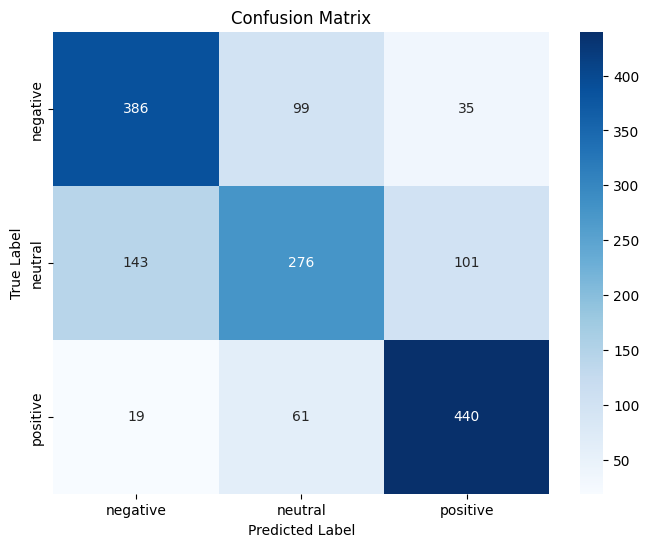

In [20]:
import matplotlib.pyplot as plt

# Confusion Matrix Visualization
cm = confusion_matrix(test_labels, test_preds)
class_names = label_encoder.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [24]:
# Save the Final Model and Tokenizer
save_directory = "/content/drive/MyDrive/cnn622/final_model"
model.save(f"{save_directory}/model.keras")  # Specify .keras extension
import pickle
with open(f"{save_directory}/tokenizer.pkl", 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Model and tokenizer saved to {save_directory}")

Model and tokenizer saved to /content/drive/MyDrive/cnn622/final_model
